In [ ]:
# conda create -n "pandasai" python=3.10 ipython
# %pip install pandasai

In [11]:
import os
import pandas as pd
from fileinput import filename
import random
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce


In [12]:
csv_folder = '.csv'
csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]

# List to hold individual dataframes
dfs = []
for file in csv_files:
    file_path = os.path.join(csv_folder, file)
    df = pd.read_csv(file_path)

    # Make all column names uppercase
    df.columns = df.columns.str.upper()

    # Replace special characters in column names with '_'
    df.columns = df.columns.str.replace(r'\W', '_', regex=True)

    # if year column is not present, print the file name
    if 'YEAR' not in df.columns:
        print(f'Year column not found in {file}')

    # if there are missing values in the 'Year' column, print the file name
    if df['YEAR'].isnull().values.any():
        print(f'Missing values in Year column in {file}')

    # If rows are more than 5, print the file name, and drop the extra rows
    if len(df) > 5:
        print(f'More than 5 rows in {file}')
        # drop extra rows where year is not 2020, 2021, 2022, 2023, 2024
        df = df[df['YEAR'].isin([2020, 2021, 2022, 2023, 2024])]

    dfs.append(df)

# Merge all DataFrames on the 'Year' column
combined_df = reduce(lambda left, right: pd.merge(left, right, on='YEAR', how='outer'), dfs)

# Convert all columns to numeric
combined_df = combined_df.apply(pd.to_numeric, errors='coerce')

# Replace 0 with forward fill and backward fill
combined_df = combined_df.replace(0, np.nan).ffill().bfill()

# Remove column where all values are 0 or NaN or missing values
combined_df = combined_df.dropna(axis=1, how='all')

# Convert all columns to numeric (round to 0 decimal places)
combined_df = combined_df.apply(pd.to_numeric, errors='coerce')
combined_df = combined_df.round(2)

# Move SCORE_AR to the last column
cols = list(combined_df.columns)
cols.remove('SCORE_AR')
cols.append('SCORE_AR')
combined_df = combined_df[cols]


# Save the combined dataframe to a new CSV file
combined_df.to_csv('data/00_processed.csv', index=False)

combined_df.head()

Missing values in Year column in Outbound Inbound.csv
More than 5 rows in Outbound Inbound.csv
More than 5 rows in Project_Areas.csv


,YEAR,ALUMNI_NATIONAL,ALUMNI_AFRICA,ALUMNI_ASIA,ALUMNI_CENTRAL_AMERICA_AND_CARIBBEAN,ALUMNI_EUROPEAN_UNION,ALUMNI_NORTH_AMERICA,ALUMNI_REST_OF_EUROPE,ALUMNI_SOUTH_AMERICA,ALUMNI_LAIN_LAIN,...,CITATION__1000_3000,CITATION_3000_5000,CITATION_5000_10000,MENTION_NEGATIVE,MENTION_NEUTRAL,MENTION_POSITIVE,CONSULTATION_CONFERENCE_SEMINAR,CONSULTATION_CONSULTANCY,CONSULTATION_TRAINING_SHORTCOURSES,SCORE_AR
0,2020,4925,50,99,1.0,1.0,4.0,2.0,1.0,16,...,20,4,3,1.0,45.0,33.0,12.0,15.0,4.0,39.4
1,2021,6942,226,589,1.0,2.0,1.0,2.0,1.0,6,...,20,4,3,2.0,42.0,59.0,22.0,10.0,5.0,42.4
2,2022,8659,275,763,1.0,2.0,1.0,4.0,1.0,21,...,20,4,3,2.0,2.0,59.0,15.0,17.0,10.0,44.5
3,2023,7289,257,849,1.0,2.0,1.0,2.0,1.0,11,...,20,4,3,2.0,2.0,1.0,20.0,16.0,20.0,46.6
4,2024,6815,265,828,1.0,1.0,4.0,4.0,1.0,8,...,19,4,3,1.0,2.0,3.0,20.0,16.0,20.0,48.6


## Insights on the available dataset

Given that we have data with 5 rows and 71 columns, it is challenging to build a robust forecasting model with only 5 data points. Typically, **time series forecasting models require more historical data to capture trends and seasonality effectively**.

Here are some steps we took to proceed:

- Explore the Data: Visualize the data to understand its trends and patterns.
- Feature Engineering: Create additional features if necessary, such as lagged variables or rolling averages.
- Model Selection: Choose an appropriate forecasting model based on your data characteristics.
- Model Evaluation: Split the data into training and testing sets to evaluate the model's performance.

The dataset is insufficient, and we can't collect more historical data to improve the forecasting accuracy.

We were tried two techniques to solve the insufficient datasets:

1. Bootstrap: This technique involves repeatedly sampling from the dataset with replacement to create multiple "bootstrap" samples. It can help estimate the distribution of a statistic (e.g., mean, variance) and improve the robustness of models by providing multiple training sets. However, it does not create new data points and does not effective when the original dataset is very small. We observed that when training the data over the small initial dataset, (we sample up to 1000 rows of data), the forecasted score does not exceed the score that it was trained on, ranging from 42 to 48 score.

2. SMOTE: This technique is used to address class imbalance in classification problems by generating synthetic samples for the minority class. It is not typically used for time series forecasting or regression problems.

Instead, we tried the following approaches:

1. Rolling Window: Use a rolling window approach to create more training samples from the existing data.
2. ARIMA: 

## Rolling Window

A rolling window approach is a technique used in time series analysis to create multiple training samples from a single dataset. This method involves using a fixed-size window that "rolls" through the data, creating overlapping subsets that can be used for model training and validation. This approach helps in making better use of limited data and can improve the robustness of the model.

Here's how we implement a rolling window approach:

1. Define the Window Size: Choose the size of the window (number of time steps) that will be used to create each training sample.
2. Create Training Samples: Slide the window across the dataset to create multiple overlapping training samples.
3. Train and Validate the Model: Use each training sample to train the model and validate its performance.

To ensure we have enough data for train and test, we do need to do bootstrap (200 rows) to increase sample size

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Bootstrap sampling to create 200 rows of data
bootstrap_samples = []
for i in range(200):
    bootstrap_samples.append(combined_df.sample(n=1, replace=True))

# Concatenate the bootstrap samples
bootstrap_df = pd.concat(bootstrap_samples)

# Preserve the original YEAR and SCORE_AR values
years = bootstrap_df['YEAR'].values
scores = bootstrap_df['SCORE_AR'].values

# Apply MinMax scaling to the other columns
scaler = MinMaxScaler()
bootstrap_df_scaled = pd.DataFrame(scaler.fit_transform(bootstrap_df.drop(columns=['YEAR', 'SCORE_AR'])), columns=bootstrap_df.columns.drop(['YEAR', 'SCORE_AR']))

# Add the preserved YEAR and SCORE_AR values back to the dataframe
bootstrap_df_scaled['YEAR'] = years
bootstrap_df_scaled['SCORE_AR'] = scores

# Save the bootstrap dataframe to a new CSV file
bootstrap_df_scaled.to_csv('data/00_bootstrap.csv', index=False)

bootstrap_df_scaled.head()

,PUBLICATION_REVIEW_PAPER,PUBLICATION_FLAGSHIP_JOURNALS,PUBLICATION_Q1_Q2,PUBLICATION_WOS_INDEXED_JOURNAL,PUBLICATION_SCOPUS_INDEX_JOURNAL,PUBLICATION_INDEXED_PROCEEDING,PUBLICATION_PROCEEDING,PUBLICATION_RESEARCHBOOK,PUBLICATION_TEXTBOOK,PUBLICATION_EDITEDBOOK,...,CITATION_3000_5000,CITATION_5000_10000,CONSULTATION_CONFERENCE_SEMINAR,CONSULTATION_CONSULTANCY,CONSULTATION_TRAINING_SHORTCOURSES,MENTION_NEGATIVE,MENTION_NEUTRAL,MENTION_POSITIVE,YEAR,SCORE_AR
0,0.000000,0.717949,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.5,0.5,...,0.0,0.0,0.000,0.714286,0.000000,0.0,1.0,0.551724,2020,39.4
1,0.000000,0.717949,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.5,0.5,...,0.0,0.0,0.000,0.714286,0.000000,0.0,1.0,0.551724,2020,39.4
2,0.000000,0.717949,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.5,0.5,...,0.0,0.0,0.000,0.714286,0.000000,0.0,1.0,0.551724,2020,39.4
3,0.000000,0.717949,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.5,0.5,...,0.0,0.0,0.000,0.714286,0.000000,0.0,1.0,0.551724,2020,39.4
4,0.495833,0.586538,0.674883,0.446927,0.382258,0.470356,0.315661,0.52439,0.0,0.5,...,0.0,0.0,0.525,0.642857,0.359375,0.0,0.0,0.034483,2024,48.6


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

# Assuming combined_df is your dataframe with a 'YEAR' column and 'SCORE_AR' as the target variable
window_size = 3  # Define the window size
target_column = 'SCORE_AR'

# Create a rolling window function
def create_rolling_window(df, window_size, target_column):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i + window_size].drop(columns=[target_column]).values)
        y.append(df.iloc[i + window_size][target_column])
    return np.array(X), np.array(y)

# Prepare the data
X, y = create_rolling_window(bootstrap_df_scaled, window_size, target_column)

# Reshape X to fit the model
n_samples, n_timesteps, n_features = X.shape
X = X.reshape((n_samples, n_timesteps * n_features))

# Split the data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Validate the model
    y_pred = model.predict(X_test)
    print(f'Test set score: {model.score(X_test, y_test)}')

# Forecast the next 5 years
forecasts = []
current_window = bootstrap_df_scaled.iloc[-window_size:].drop(columns=[target_column]).values.flatten().reshape(1, -1)

for _ in range(5):
    forecast = model.predict(current_window)
    forecasts.append(forecast[0])
    
    # Update the current window with the new forecast
    new_row = np.append(current_window[0, n_features:], forecast)
    current_window = np.roll(current_window, -n_features)
    current_window[0, -n_features:] = forecast

# Print the forecasts
for i, forecast in enumerate(forecasts, start=1):
    print(f'Forecast for year {2024 + i}: {forecast}')

Test set score: 0.923591569841086
Test set score: -8.416143001889605
Test set score: 0.0
Test set score: -2.7316021936793235e+19
Test set score: -2.213563355145746
Forecast for year 2025: 40.0
Forecast for year 2026: 7995986218565072.0
Forecast for year 2027: 5.444400518570659e+28
Forecast for year 2028: 3.707047035398439e+41
Forecast for year 2029: 2.524097497195915e+54


The issue with the forecasts for the years 2027-2029 likely stems from the following factors:

- Model Instability: Linear regression models can become unstable when extrapolating far beyond the range of the training data, especially if the data has non-linear patterns or trends that the model cannot capture.

- Error Propagation: In a rolling window approach, each forecast is used as an input for the next forecast. Any errors in the initial forecasts can propagate and amplify in subsequent forecasts, leading to unrealistic predictions.

- Insufficient Data: With only 5 data points, the model may not have enough information to accurately capture the underlying patterns and trends, leading to poor generalization.

- Feature Scaling: If the features are not properly scaled, the model coefficients can become very large, leading to numerical instability and extreme forecast values.

To address these issues, consider the following steps:

- Use a More Robust Model: Consider using more advanced time series forecasting models like ARIMA, Prophet, or LSTM, which are better suited for capturing trends and seasonality in time series data.

- Feature Scaling: Ensure that the features are properly scaled (e.g., using StandardScaler or MinMaxScaler) to prevent numerical instability.

- Model Validation: Use cross-validation techniques to evaluate the model's performance and ensure it generalizes well to unseen data.

- Error Analysis: Analyze the residuals (errors) of the model to identify any patterns or trends that the model is not capturing.

## ARIMA

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Load the combined dataframe
combined_df = pd.read_csv('data/00_processed.csv')

# combined_df is our dataframe with a 'YEAR' column and 'SCORE_AR' as the target variable
target_column = 'SCORE_AR'

# Convert 'YEAR' to a DateTime index
combined_df['YEAR'] = pd.to_datetime(combined_df['YEAR'], format='%Y')
data = combined_df.set_index('YEAR')[target_column]

# Fit the ARIMA model
model = ARIMA(data, order=(5, 1, 0))  # Adjust the order parameters as needed
model_fit = model.fit()

# Forecast the next 5 years
forecast_steps = 6  # Adjust the forecast steps as needed
forecast = model_fit.forecast(steps=forecast_steps)

# Print the forecasts
for i, forecast_value in enumerate(forecast, start=1):
    print(f'Forecast for year {2024 + i}: {forecast_value}')


Forecast for year 2025: 50.56952550191212
Forecast for year 2026: 52.49312005690062
Forecast for year 2027: 54.37923499445984
Forecast for year 2028: 56.226360526315
Forecast for year 2029: 58.036199534305844
Forecast for year 2030: 59.809206185634146


c:\Users\sharu\.conda\envs\pandasai\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\sharu\.conda\envs\pandasai\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\sharu\.conda\envs\pandasai\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\sharu\.conda\envs\pandasai\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


## Feature Importance

                                              Feature  Importance
59                                  CITATION_500_1000    0.063583
58                                   CITATION_100_500    0.059178
29  PROJECT_AREAS_SMART_LIVING_AND_SUSTAINABLE_CITIES    0.045467
68                 CONSULTATION_TRAINING_SHORTCOURSES    0.036752
51                                            OVERALL    0.031117
64                                    MENTION_NEUTRAL    0.030564
12                    PUBLICATION_WOS_INDEXED_JOURNAL    0.027847
53                                  SENTIMENT_NEUTRAL    0.027814
67                           CONSULTATION_CONSULTANCY    0.026274
24  PROJECT_AREAS_BIOMEDICAL_AND_HEALTHCARE_ENGINE...    0.026204
19                   PUBLICATION_RESEARCHBOOK_CHAPTER    0.026155
20            PUBLICATION_OTHERARTICLE_TECHNICALPAPER    0.025535
16                           PUBLICATION_RESEARCHBOOK    0.025322


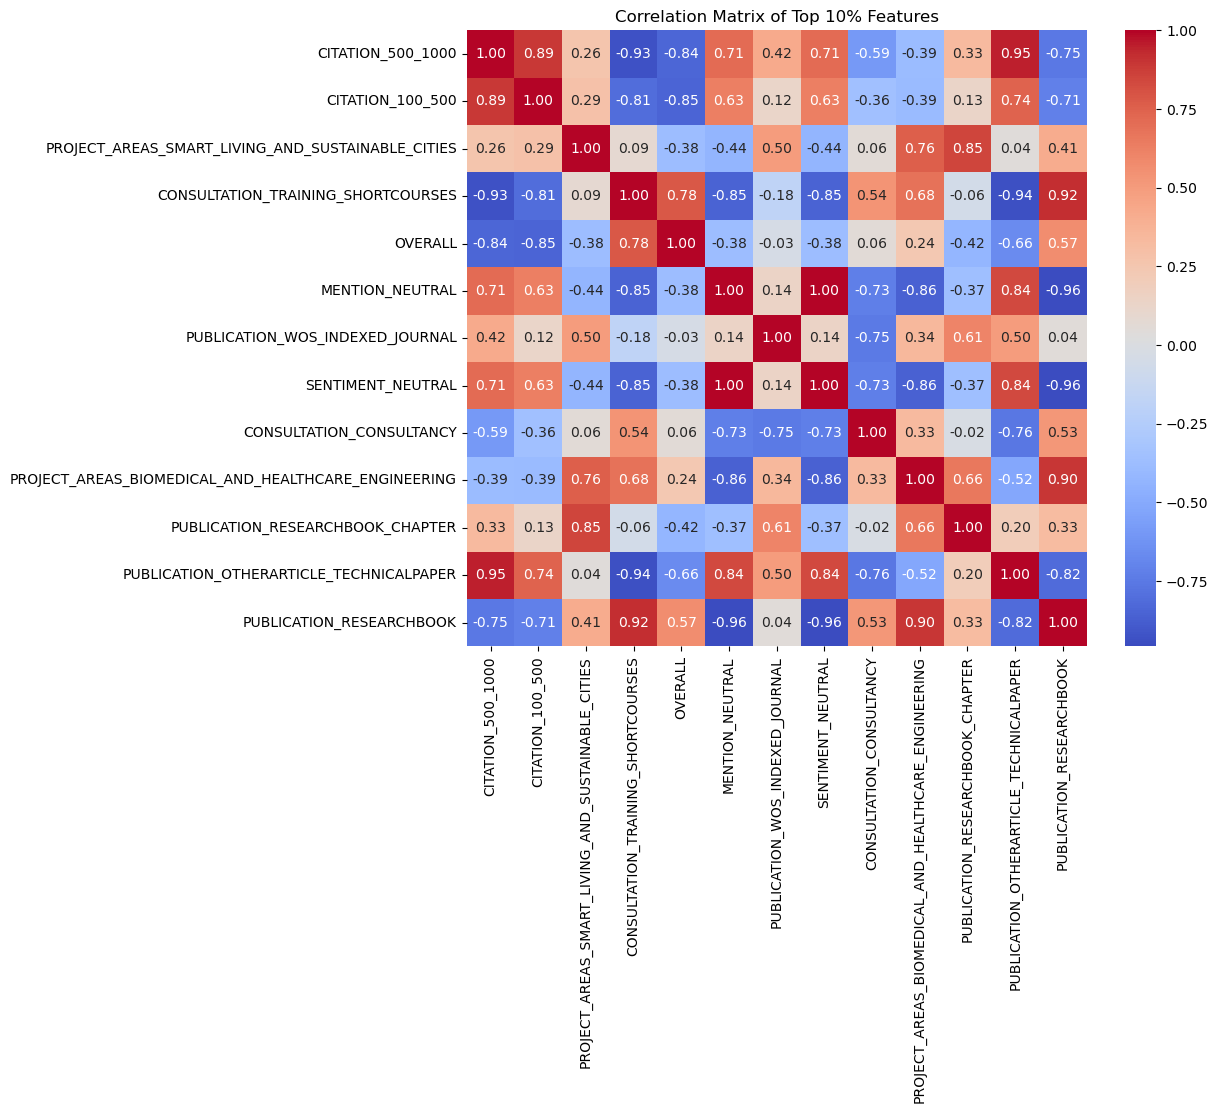

In [72]:
# Feature Importance
from sklearn.ensemble import RandomForestRegressor

# Assuming combined_df is your dataframe with a 'YEAR' column and 'SCORE_AR' as the target variable
X = combined_df.drop(columns=['YEAR', 'SCORE_AR'])
y = combined_df['SCORE_AR']

# Fit a RandomForestRegressor model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display the feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Top 10% features
top_10_features = feature_importances_df.head(int(len(feature_importances_df) * 0.2))

# Print the feature importances
print(top_10_features)

# Plot the correlation matrix of the top 10% features
top_10_feature_names = top_10_features['Feature'].values
top_10_feature_matrix = combined_df[top_10_feature_names].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(top_10_feature_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Top 10% Features')
plt.show()

## Forecasting Chart

C:\Users\sharu\AppData\Local\Temp\ipykernel_16936\738508597.py:5: FutureWarning: 'AS-JAN' is deprecated and will be removed in a future version, please use 'YS-JAN' instead.
  forecast_index = pd.date_range(


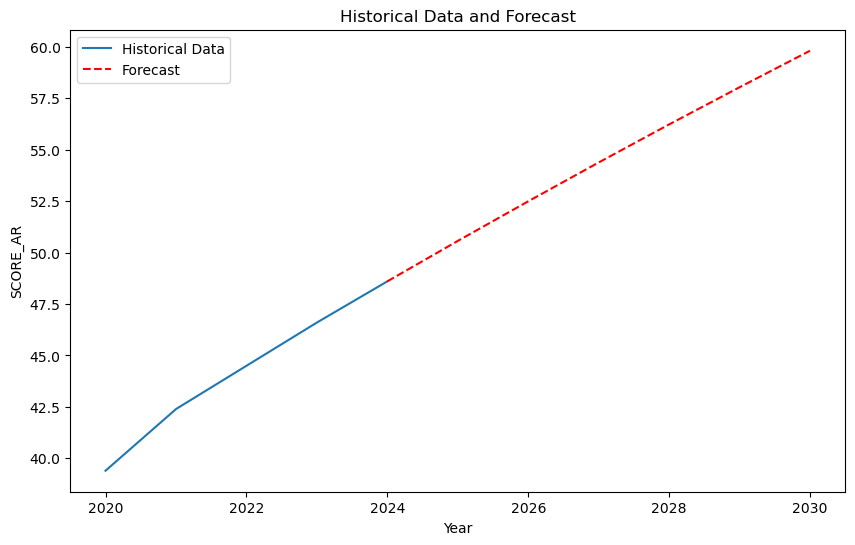

In [ ]:

# Create a DataFrame for the forecasted values
last_date = data.index[-1]  # This is 2024-01-01
last_value = data.iloc[-1]

forecast_index = pd.date_range(
    start=last_date,  # Start from last historical date
    periods=forecast_steps + 1,  # Add 1 to include the last historical point
    freq='YS-JAN'
)
forecast_values = np.concatenate(([last_value], forecast.values)) # Include the last historical point
forecast_df = pd.DataFrame({'SCORE_AR': forecast_values}, index=forecast_index)

# Concatenate the historical data and the forecasted values
combined_data = pd.concat([data, forecast_df.iloc[1:]])  # Exclude the overlapping point

# Plot the historical data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(data, label='Historical Data')
plt.plot(forecast_df, label='Forecast', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel(target_column)
plt.title('Historical Data and Forecast')
plt.legend()
plt.show()